# Part 1 

In [1]:
import glob
import numpy as np
from collections import Counter 
import scipy.stats as sts

In [2]:
path = 'symbol/*'

languages = ['A', 'B', 'C']
chars = ["A", "o", "e", "t", "p", "g","k"]

In [3]:
train_A = [file for file in glob.glob(path) if "langA" in file]
train_B = [file for file in glob.glob(path) if "langB" in file ]
train_C = [file for file in glob.glob(path) if "langC" in file]

test = [file for file in glob.glob(path) if "test" in file ]

In [4]:
n = len(chars)
m = len(languages)

In [5]:
## Adapted and commented from StackOverflow 
#(https://stackoverflow.com/questions/46657221/generating-markov-transition-matrix-in-python)


def transition_matrix(transitions):
    
    n = len(chars) #number of states
    
    #build the matrix
    A = np.zeros((n, n))

    #for each training data observation
    for trans in transitions:
        
        #build a matrix
        M = np.zeros((n, n))
        
        #for each transition that occurs for a pair of characters
        for (i,j) in zip(trans,trans[1:]):
            #add one
            M[chars.index(i)][chars.index(j)] += 1

        #now convert to probabilities:
        for row in M:
            #get the number of all transitions for one character
            s = sum(row)
            #divide by the total
            if s > 0:
                row[:] = [f/s for f in row]
        
        #add this to the overall matrix
        A += M
    
    #normalize the output matrix.
    #now convert to probabilities:
    for row in A:
        #get the number of all transitions for one character
        s = sum(row)
        #divide by the total
        if s > 0:
            row[:] = [f/s for f in row]   
    
    
    return A

In [6]:
open_A = []
for file in train_A:
    
    with open(file) as f:
        open_A.append(f.read())

open_B = []
for file in train_B:
    
    with open(file) as f:
        open_B.append(f.read())


open_C = []
for file in train_C:
    
    with open(file) as f:
        open_C.append(f.read())
    

In [7]:
transition_A = transition_matrix(open_A)
#print(transition_A)

transition_B = transition_matrix(open_B)
#print(transition_B)

transition_C = transition_matrix(open_C)
#print(transition_C)


In [8]:
## Testing if the rows sum to 1
for no_mat, matrix in enumerate([transition_A, transition_B, transition_C]):
    
    for no_row, row in enumerate(matrix):
        
        if round(sum(row),12) != 1:
            print(no_mat, no_row)
            print(sum(row))

We don't know how likely a character is to happen in the sequences so we will estimate it using the data. 

In [9]:
# initial distribution 
all_files = np.asarray([[list(seq) for seq in open_A], 
                        [list(seq) for seq in open_B], 
                        [list(seq) for seq in open_C]]).flatten()

#how likely is any character?
dis  = Counter(all_files)

initial_distribution = np.zeros(n)

for char, count  in enumerate(dis):
    initial_distribution[char] = dis[count]
    
initial_distribution = initial_distribution/sum(initial_distribution)
print(initial_distribution)

for i, char in enumerate(dis):
    dis[char] = initial_distribution[i] 
    
dis

[0.159      0.10577778 0.167      0.15388889 0.14888889 0.09155556
 0.17388889]


Counter({'t': 0.159,
         'p': 0.10577777777777778,
         'A': 0.167,
         'o': 0.15388888888888888,
         'g': 0.14888888888888888,
         'k': 0.09155555555555556,
         'e': 0.1738888888888889})

In [10]:
open_test = []
for file in test:
    with open(file) as f:
        open_test.append(f.read())

In [11]:
def likelihood(char_set, transition_mat):
    
    #sum up all the log transitions
    log_likelihood = np.sum([np.log(transition_mat[chars.index(t),
                                                     chars.index(t1)])
                                   
                                    for t, t1 in zip(char_set, char_set[1:])]) 
    #add the initial likelihood of that value
    log_likelihood += np.log(dis[char_set[0]])
    
    return log_likelihood
    
def prob_languages(test_seq, matrices):

    
    lang_prob = np.array([likelihood(test_seq, mat) for mat in matrices]
    
    #prior
    log_prior = np.log(np.ones(len(matrices),)/len(matrices))
    
    #multiply the prior with the likelihood (or add the logs)
    lang_prob = lang_prob + log_prior
    
    # for avoid underflow
    lang_prob = lang_prob - np.max(lang_prob)
    
    # exponentiate, no longer in log space
    lang_prob = np.exp(lang_prob)

    #normalize
    lang_prob /= np.sum(lang_prob)
    #
    print(f"{languages[np.argmax(lang_prob)]} is most likely with a prob. of {lang_prob[np.argmax(lang_prob)]}")
    print("Entire distribution:", lang_prob)
    
    return lang_prob

In the prob_languages function I use Bayes' Theorem by taking the likelihood of a language being spoken by a given speaker and multiply it by the prior. The whole thing is normalized by dividing by the area under the curve for the entire distribution of the snipped belonging to a speaker. 

In [12]:
for testcase in open_test:
    
    prob_languages(testcase, [transition_A, transition_B, transition_C])
    print()

B is most likely with a prob. of 1.0
Entire distribution: [1.89289823e-46 1.00000000e+00 4.01805937e-53]

A is most likely with a prob. of 1.0
Entire distribution: [1.00000000e+00 0.00000000e+00 3.16636336e-44]

A is most likely with a prob. of 1.0
Entire distribution: [1.0000000e+00 0.0000000e+00 7.4694811e-38]

A is most likely with a prob. of 1.0
Entire distribution: [1.00000000e+00 0.00000000e+00 3.34707883e-32]

A is most likely with a prob. of 1.0
Entire distribution: [1.00000000e+00 0.00000000e+00 7.37601306e-39]

C is most likely with a prob. of 1.0
Entire distribution: [2.25521774e-63 0.00000000e+00 1.00000000e+00]

A is most likely with a prob. of 1.0
Entire distribution: [1.00000000e+00 0.00000000e+00 5.43804953e-44]

C is most likely with a prob. of 1.0
Entire distribution: [3.56088182e-84 0.00000000e+00 1.00000000e+00]

C is most likely with a prob. of 1.0
Entire distribution: [3.79629213e-71 0.00000000e+00 1.00000000e+00]

B is most likely with a prob. of 1.0
Entire distr

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


## Part 2

In a HMM the state that produces the output is unknown and we have to infer it using the Baum-Welch or Forward-Backward algorithm.
What follows is my best shot at implementing the algorithm. 

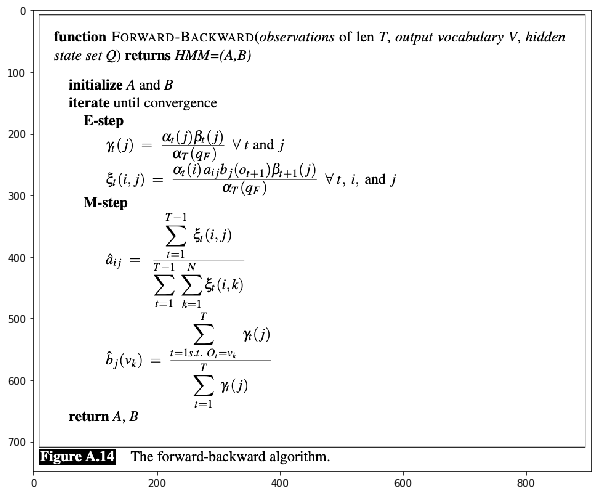

In [35]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread("For_Back_Algo.png")
plt.figure(figsize = (10,10))
plt.imshow(image)
plt.show()

Figure 1. Forward backward algorigthm (Jurafsky & Martin, 2009).

Where $\hat{a}_{ij}$ and $\hat{b}_{j}(v_k)$  and the transition and emission matrices respectively.
How to calculate alpha and beta is given below and also taken from Jurasfsky and Martin (2009).

### Forward:

$\alpha$ is the probability of being at the current state given the previous observation, given the automaton $\lambda$.

1. Initialization:
    
    $\alpha_1(j) = \pi_jb_j(o_1)$
    

2. Recursion:
    
    $\alpha_t(j) = \sum_{i = 1}^{N}{\alpha_{t-1}(i)a_{ij}b_j(o_t)}$

    
### Backward

$\beta$ is the probability of seeing the observations from time t + 1 to the end, given we are at state i at time t (and $\lambda$). 

1. Intitialization:
    
    $\beta_T(i) = 1, 1 ≤ i ≤ N $
    
    
2. Recursion:

    $\beta_t(i) = \sum_{j = 1}^{N}{a_{ij}b_j(o_{t+1}\beta_{t+1}(j)} , 1 ≤ i ≤ N, 1 ≤ t < T$
    

In [14]:
import matplotlib.pyplot as plt
import numpy as np

import scipy.stats as sts

In [15]:
speech = 'eoggeggAeggepgpppoppogopppgoppoopegAAoAAAtAtttooepooppteeeeotpopppeeoepooopopgoooepoepotpoegogggggkeggpogopopeAtAttAoApAtttAggeAgegettttAAAAtoeeggeteoAopopotoktttpoepegpgtgAgAeeppeoooopgeggpAAAAgAtgegogoeepAtAtAAotAAAtttAtkAAAtAAktAAAtttAtAAoAtteeoopoAoAtoAAtAAApgeoeeeeoeeegteoAopeAkopgpeAgetAeeotAttAAeAAktttkAptAetAttAkAAAttAAkAAAttAAAAgAgkgogppgooApkpoAopopptotegoAppppAgettgtteAtttAAttAtpoooopopkeogeeettgtAAttAtAtttpopptoAokpopooooAooeoopopptoopgpAAootAtgtpgeeeeegegeAkeAgtoAoAooepgeegegeegekeegtoAAttttttggeegkeegggetgggggeggegeAgpoooktoppoopApoooAtAeAgegegoegeAgpeotppogpoppppoppoppoootAtAAAtApopoopooooopopppopoppoottoopopookAtAAAtettApAtttooAAtteeoAttppeAgtpeegoeeAtoAteeAeeppopekotktetppgpkgktopAAtkkgegttAAtoopopkeAApgoAotteegegeogkoggpAggpkAgAttttAAtAttAteeeopoetAttAtkeoAopgtAtktgtgttopooppgopppppppopeooAptoopopAookApoggtpttttoAoppoopAppoAoppooppptpAooppppppoooAAAtttttttAtteegggeeoeegeoeggkettkAAoAkAAteeggggkAgAtpAAAttAtAAAptAeppAAAopppAApkeeokpeegpppekpegeeeteoopoApoookoogggegekopo'
pi = [1/3,1/3,1/3]


chars = ["A", "o", "e", "t", "p", "g","k"]

obs = [chars.index(p) for p in speech]

speakers = [0,1,2]


In [108]:
def baum_welch(observations,  speakers, initial_A, initial_B):
    
    """
    func: baum_welch
    
    Implements the baum welch algorithm. Uses Expectation Maximisation 
    to find the most likely transition and emission matrices.
    
    in:
    - observations (list of ints): The data of the observed variables in list format and converted to integers.
    - Speakers (list of ints):     A list with of hidden states. 
    - initial_A:                   The suspected transition matrix. Entries should not be the same. sum(Row) = 1.
    - initial_B:                   The suspected transition matrix. Entries should not be the same. sum(Row) = 1.
    """
    
    
    
    def forward_log(O, N, trans_mat, emmission_mat):
        
        """
        func: forward_log
        Calculates the log probability of being at the current state given the previous observation, given the automaton lambda (A and B).
        
        
        Inputs:
        O: observations
        N: number of hidden states
        trans_mat: Transition matrix
        emmission_mat: Emission matrix
        
        Outputs:
        forward_mat_log: The log forward probabilities.
        """
    
        pi = np.ones(N)/N

        T = len(O)
        #build matrix
        forward_mat_log = np.zeros((N, len(O)))

        #initialize 
        for s in range(N):
            forward_mat_log[s, 0] = np.log(pi[s]) + np.log(emmission_mat[s, O[0]])


        #recursion 
        for t in range(1, T):

            #calculate the forward probs at this time step using the previous and current time steps.
            col = np.log(sum(np.exp([forward_mat_log[s_dash, t-1] 
                                    + np.log(trans_mat[s_dash, :]) 
                                    + np.log(emmission_mat[:, O[t]])
                                    for s_dash in range(N)])))

            #subtract the max to avoid underflow. 
            col -= col.max()
            
            col -= np.log(np.sum(np.exp(col)))

            forward_mat_log[:, t] = col.copy()

        return forward_mat_log

    def backward_log(O, N, trans_mat, emmission_mat):
        
        """
        func: backward_log
        log probability of seeing the observations from time t + 1 to the end, given we are at state i at time t (and lambda). 
        
        Inputs:
        O: observations
        N: number of hidden states
        trans_mat: Transition matrix
        emmission_mat: Emission matrix
        
        Outputs:
        backward_mat_log: The log backward probabilities
        """

        T = len(O)
        #build matrix
        backward_mat_log = np.zeros((N, len(O)))

        #initialize
        for i in range(N):
            backward_mat_log[i, -1] = np.log(1) #actually just zero but i'll keep this for completion sake.

        #recursion
        #for each obsv.
        for t in range(T - 2, 0, -1):

            #calculate the backward log distribution
            col = np.log(sum([np.exp(backward_mat_log[j, t + 1] 
                                    + np.log(trans_mat[:, j])
                                    + np.log(emmission_mat[:, O[t + 1]]))
                                    for j in range(N)]))

            #avoid underflow
            col -= col.max()
            
            #normalize
            col -= np.log(np.sum(np.exp(col)))

            backward_mat_log[:, t] = col.copy() 

        return backward_mat_log

    #gives the probability of state j at time t. 
    def gamma_log(forward_log, backward_log):
        
        """
        func: gamma_log
        
        Inputs:
        forward_log: The log forward probability 
        backward_log: The log backward probability 
        
        Outputs:
        gamma_log: the probability of state j at time t
        """


        numerator = np.asarray(forward_log) + np.asarray(backward_log)
        
        gamma_log = numerator - numerator.max(axis = 0)
        
        gamma_log = np.log(np.exp(gamma_log) / np.sum(np.exp(gamma_log), axis = 0))
        

        return gamma_log

    #defining the function to calculate the Xi 
    #which gives the probability of transitioning from state i to state j at time t.
    def xi_log(a_log, b_log, trans_mat, em_mat, O):
        
        '''
        func: xi_log
        
        Inputs: 
        - a_log: the log forward probabilities
        - b_log: the log backward probabilities
        - trans_mat:     Transition matrix
        - em_mat:     Emission matrix
        - O:     Observations
        
        
        Output:
        x_mat: Log probability of transitioning from state i to state j at time t. (shape: (T-1, N, N))
        
        '''

        N = len(trans_mat[0])
        T = len(O)

        xi_mat = []

        numerator = np.asarray(a_log) + np.asarray(b_log)

        denom = numerator.max(axis = 0)

        for t in range(len(O) - 1):

            t_mat = np.zeros((N, N))

            for i in range(N):
                for j in range(N):

                    #P(i | t)* P(j | i) * P(j | t +1) * P(j | t+1)
                    numer = a_log[i, t] + np.log(trans_mat[i, j]) + np.log(em_mat[j, O[t +1]]) + b_log[j, t +1]  
                    
                    #normalizing by the probability of any state happening at t
                    t_mat[i, j] = numer - np.log(sum([np.exp(a_log[j, t] + b_log[j, t]) for j in range(N)]))
                
                
                #reducing the value here to prevent computational underflow. 
            t_mat -= max([max(t_mat[:, j]) for j in range(N)])

            xi_mat.append(t_mat)

        return xi_mat
    
    
    
    pi = [1/3,1/3,1/3]
    O = observations.copy()
    H = speakers.copy()
    N = len(H)
    T = len(O)
    
    
    print("Initializing with: \n")
    print("\pi:", pi)
    print("N", N)
    print("T", T)
    
    A = initial_A
    B = initial_B
    
    print('\nA:\n', A,  '\n')

    print('B:\n', B,  '\n') 
    
    change_a = 1
    change_b = 1
    
    #find the occurrence indeces
    occurrences = [[i for i, x in enumerate(O) if x == k] for k in range(7)] 
    if len(occurrences) != T:
        assert "something wrong with occurrence counting"
    
    #count the number of times EM runs
    runs = 0
    
    print("... Running EM ...")
    
    
    ## The main EM Loop
    while change_a > 0.0001 or change_b > 0.0001: #change_a and change_b are checked for convergence. We can adjust these with time/accuracy trade off
        
        runs += 1
        
        ## E - step:
        
        #calling on the forward function
        alphas_log = forward_log(O, N, A, B).copy()
        
        #calling on the backward function
        betas_log  = backward_log(O, N, A, B).copy()
        
        #calculating probability of being in state at time t
        gammas_log = gamma_log(alphas_log, betas_log).copy()
        
        #probability of being in state i at time t and state j at time t+1, given observations and model
        xis_log = xi_log(alphas_log, betas_log, A, B, O).copy()
        
        
        
        ## M - step
        
        #compute the next A
        A_hat = np.zeros((N, N))
        
        #for each transition
        for i in range(N):
            
            for j in range(N):
        
                #probability of going from hidden state i to hidden state j
                a_ij_top = np.sum([np.exp(xis_log[t][i, j]) for t in range(T-1)])
                a_ij_bot = np.sum([np.sum([np.exp(xis_log[t][i, k]) for k in range(N)]) for t in range(T-1)])
                
                #insert the value. Transformed it into log space and back to avoid under-/overflow
                A_hat[i, j] = np.exp(np.log(a_ij_top) - np.log(a_ij_bot))
                
            
        #compute the next B
        B_hat = np.zeros((N, 7))
        
        for j in range(N):
            
            # we can iterate through numbers for the characters since we have converted them 
            for k in range(7):
                
                #calculate the probability of seeing character k when in state j
                jk_top = sum([np.exp(gammas_log[j, t]) for t in occurrences[k]])
                jk_bot = sum([np.exp(gammas_log[j, t]) for t in range(T)])
                
                B_hat[j, k] = np.exp(np.log(jk_top) - np.log(jk_bot))
                
        #check for convergence
        change_a = np.mean(np.mean(abs(A_hat - A)))
        change_b = np.mean(np.mean(abs(B_hat - B)))
       
        A = A_hat.copy()
        B = B_hat.copy()
        
        if runs%10 == 0:
            print(f"{runs} EM rounds with average ∆A: {change_a}; average ∆B: {change_b}")
                
    
    #make sure the rows sum to 1
    for row in A:
        if round(sum(row), 8) != 1:
            assert "Rows in A don't sum to one"
   
    for row in B:
        if round(sum(row), 8) != 1:
            assert "Rows in B don't sum to one"

        
    print(f"The EM algorithm ran {runs} times")          
    return A, B, alphas_log, betas_log

## initialize the matrix for A to reflect the 90% chance of sticking with the speaker. 
A_prior = np.asarray([[.9, .051, .049],
         [.051, .90, .049],
         [.051, .049, .9]])
    
B_prior = np.ones((3, 7))/7 #emission: from each speaker to each phenome

for row in range(3):
    #initialize them with different values
    B_prior[row] = sts.dirichlet.rvs(B_prior[row])

A_max, B_max, alpha_final, beta_final = baum_welch(obs[:], speakers, A_prior, B_prior)


print('A\n', A_max,  '\n')

print('B\n', B_max,  '\n') 

Initializing with: 

\pi: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
N 3
T 1000

A:
 [[0.9   0.051 0.049]
 [0.051 0.9   0.049]
 [0.051 0.049 0.9  ]] 

B:
 [[6.58344551e-04 1.20968589e-07 5.97749511e-02 5.79058229e-03
  6.29436753e-02 6.71633386e-03 8.64115992e-01]
 [3.79586102e-01 1.39910005e-04 1.63389283e-01 1.38311326e-02
  3.76882765e-01 6.05731158e-02 5.59769168e-03]
 [1.31939580e-04 7.60136881e-03 9.83361735e-06 6.44799212e-02
  2.47841871e-05 2.75373675e-07 9.27751877e-01]] 

... Running EM ...
10 EM rounds with average ∆A: 0.017336426322040143; average ∆B: 0.007389018429424029
20 EM rounds with average ∆A: 0.0012627540543355918; average ∆B: 0.0007166900526941371
30 EM rounds with average ∆A: 9.934436688468125e-05; average ∆B: 4.6143431179196163e-05
The EM algorithm ran 30 times
A
 [[0.74133656 0.12802065 0.13064279]
 [0.11141867 0.79116312 0.0974182 ]
 [0.13240992 0.10366143 0.76392865]] 

B
 [[0.05983601 0.07161086 0.37638991 0.058299   0.06675126 0.31429399


The values in the transition matrix seem plausible. But underestimates the time for each of the speakers to not be interrupted by around 10% points. 

In [109]:
posteriors = []

#for each timestep
for t, observation in enumerate(obs):
    
    post_t = []
    for j in range(3):
        
        # \alpha_t(j) * \beta_t(j) * P(speaker | observation)
        post_t_j = alpha_final[j, t] + beta_final[j, t] + np.log(B_max[j, observation]) - np.log(sum(B_max[:, observation]))
        
        post_t.append(post_t_j) 
        
    #reduce underflow
    post_t -= max(post_t)
    
    #convert back from log space
    post_t = np.exp(post_t)
    
    #normalize
    post_t/= sum(post_t)
    
    #add to posterior list
    posteriors.append(post_t)


Text(0, 0.5, '$P(Speaker_t)$')

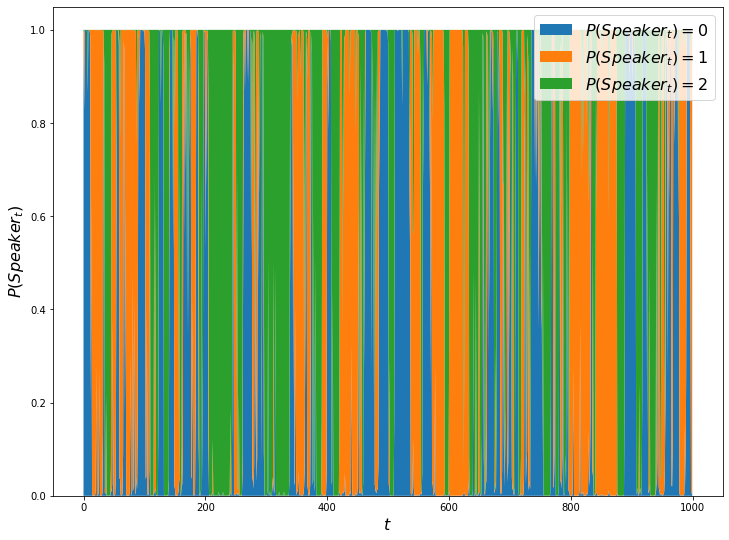

In [110]:
plt.figure(figsize=(12, 9))
x_s = range(len(obs))

speaker_1, speaker_2, speaker_3 = zip(*posteriors)


plt.stackplot(x_s, speaker_1, speaker_2, speaker_3, labels=['$P(Speaker_t) = {i}$'.format(i=i) for i in range(3)])

plt.legend(fontsize=16)
plt.xlabel('$t$', fontsize=16)
plt.ylabel('$P(Speaker_t)$', fontsize=16)

Figure 2. Stackplot of the posterior probabilities of P(S | O)

### Using my own fake data to check if I see where the output is wrong

-- I struggled with figuring out the algorithm above so to test if it was working I generated my own data so that I could see if I could pinpoint what goes wrong and check if there is a problem with the returned outputs since I  know the true transition and emission matrices.

In [115]:
state = 1
fake_data = [2]

t_mat = [[0.6, .2, .2],
        [0.2, .6, .2],
        [0.3, .1, .6]]

b_mat = [[.05,.05,.1,.2,.1,.2,.3],
        [.4,.5,.02,.02,.02,.02,.02],
        [.01,.01,.28,.4,.1,.1,.1]]


for i in range(999):

    state = np.argmax(sts.multinomial.rvs(1, p = t_mat[state]))
    fake_data.append(np.argmax(sts.multinomial.rvs(1, b_mat[state])))
    
A_max, B_max, alpha_final, beta_final = baum_welch(fake_data, speakers, np.asarray([sts.dirichlet.rvs(row)[0] for row in t_mat]), np.asarray([sts.dirichlet.rvs(row)[0] for row in b_mat]))

Initializing with: 

\pi: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
N 3
T 1000

A:
 [[9.82837802e-01 6.06601316e-03 1.10961847e-02]
 [5.82941735e-02 9.41705821e-01 5.59412556e-09]
 [2.05860563e-03 9.19766332e-01 7.81750626e-02]] 

B:
 [[1.29197305e-02 1.07748060e-04 4.20557453e-01 1.47662507e-03
  5.10607062e-04 1.78262525e-01 3.86165311e-01]
 [8.46455285e-01 1.53492340e-01 5.23742999e-05 7.55801722e-28
  1.36069720e-14 3.56081659e-16 8.79611584e-12]
 [1.14157604e-96 9.62533564e-51 8.32667445e-01 3.39665837e-04
  1.46058516e-07 1.17869566e-07 1.66992626e-01]] 

... Running EM ...
10 EM rounds with average ∆A: 0.00031248242859017766; average ∆B: 0.0007835583898952599
20 EM rounds with average ∆A: 0.004135691275402228; average ∆B: 0.003359795333964017
30 EM rounds with average ∆A: 0.0018388877116562617; average ∆B: 0.0018122582297134247
40 EM rounds with average ∆A: 0.00025196130904569115; average ∆B: 0.00039728924019196934
50 EM rounds with average ∆A: 6.1648280725913

In [116]:
print('A\n', A_max,  '\n')
print('A True \n', np.array(t_mat), '\n')


print('B\n', B_max,  '\n') 
print('B True \n', np.array(b_mat), '\n')

A
 [[7.01750376e-01 2.00500216e-01 9.77494079e-02]
 [4.02607921e-01 5.97392068e-01 1.12675006e-08]
 [8.44685015e-04 9.99155295e-01 1.97746489e-08]] 

A True 
 [[0.6 0.2 0.2]
 [0.2 0.6 0.2]
 [0.3 0.1 0.6]] 

B
 [[9.17317114e-002 7.97551186e-002 1.42798428e-001 3.60797433e-001
  1.02096217e-001 1.31868650e-001 9.09524421e-002]
 [2.96398836e-001 3.47893034e-001 7.26227008e-002 1.19683238e-016
  6.51990370e-002 1.01890329e-001 1.15996063e-001]
 [1.15581320e-100 2.54368292e-047 3.12824913e-001 2.96481630e-001
  6.23080602e-013 1.11518341e-011 3.90693457e-001]] 

B True 
 [[0.05 0.05 0.1  0.2  0.1  0.2  0.3 ]
 [0.4  0.5  0.02 0.02 0.02 0.02 0.02]
 [0.01 0.01 0.28 0.4  0.1  0.1  0.1 ]] 



While the data seem plausible, they also still have some error attached to them. 
The most "Wrong" is the emission matrix. 

__What could be done to further improve?__

- Maybe more data? 
- Underflow can be an issue. I have tried to mitigate the effect of this by converting things from and to log-space but this constant converting could lead to inaccuracies. 
- There could just be another bug somewhere. 

## Using a canned package to get the correct answer (yawn)

In [117]:
import hmmlearn as hmm
from hmmlearn.hmm import MultinomialHMM

data_converted = np.asarray(obs).reshape(-1,1)

hmm = MultinomialHMM(n_components=3, n_iter=100, init_params='ste')

hmm.transmat_prior = A_prior
hmm.emissionprob_prior = B_prior

hmm.fit(data_converted)


## The truth: 
print("The Transition Matrix given by a tested and canned package:")
print(hmm.transmat_)

print('A My BM\n', A_max,  '\n')

print("\nThe Emission Matrix given by a tested and canned package:")
print(hmm.emissionprob_)
print('B My BM\n', B_max,  '\n') 

The Transition Matrix given by a tested and canned package:
[[0.95579851 0.00158597 0.04261552]
 [0.20323229 0.65543047 0.14133724]
 [0.         0.27895557 0.72104443]]
A My BM
 [[7.01750376e-01 2.00500216e-01 9.77494079e-02]
 [4.02607921e-01 5.97392068e-01 1.12675006e-08]
 [8.44685015e-04 9.99155295e-01 1.97746489e-08]] 


The Emission Matrix given by a tested and canned package:
[[6.59553347e-02 2.58497845e-01 1.96539104e-01 3.92900450e-02
  2.40684902e-01 1.63000449e-01 3.60323203e-02]
 [2.37215583e-01 2.09158823e-05 5.78973704e-02 6.13662964e-01
  8.73274891e-03 6.91076535e-02 1.33627643e-02]
 [5.29753278e-01 8.52481716e-02 5.93461298e-03 2.70276283e-01
  2.77859784e-02 9.73918617e-03 7.12624893e-02]]
B My BM
 [[9.17317114e-002 7.97551186e-002 1.42798428e-001 3.60797433e-001
  1.02096217e-001 1.31868650e-001 9.09524421e-002]
 [2.96398836e-001 3.47893034e-001 7.26227008e-002 1.19683238e-016
  6.51990370e-002 1.01890329e-001 1.15996063e-001]
 [1.15581320e-100 2.54368292e-047 3.128249

Text(0, 0.5, '$P(Speaker_t)$')

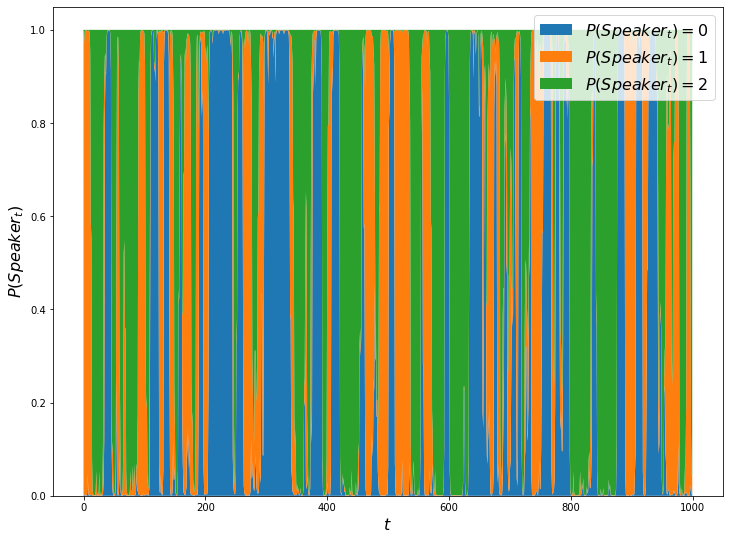

In [107]:
plt.figure(figsize=(12, 9))
x_s = range(len(data_converted))
state_post_distribution = hmm.predict_proba(data_converted)
speaker_1, speaker_2, speaker_3 = zip(*state_post_distribution)


plt.stackplot(x_s, speaker_1, speaker_2, speaker_3, labels=['$P(Speaker_t) = {i}$'.format(i=i) for i in range(3)])

plt.legend(fontsize=16)
plt.xlabel('$t$', fontsize=16)
plt.ylabel('$P(Speaker_t)$', fontsize=16)

Figure 3. Stackplot of the canned function.

This seems similarly plausbile. 

There is a difference again in both the Transition and Emission matrix. However, the overall patterns are similar. 

Main take-away is to be really careful with computational underflow and which rows/columns in matrices are used to sum over when trying to normalize something.


When comparing this to Fig. 2, we can see that the speaker identification is done wrongly, in the hand-coded algorithm. That is means there is a problem with the emission matrix attributing the phenomes wrongly. 

# References

Jurafsky, D., Martin, J. H. (2009). Speech and language processing : an introduction to natural language processing, computational linguistics, and speech recognition. Upper Saddle River, N.J.: Pearson Prentice Hall. ISBN: 9780131873216 0131873210